In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Get the datasets
df1975 = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/eb228490f7d823bfa6458b93db075ca5ccd3ec3d/finch_beaks_1975.csv')

In [3]:
df1975.head()

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [4]:
df1975['year'] = 1975

In [5]:
df1975.rename(columns = {'Beak length, mm':'beak_length','Beak depth, mm':'beak_depth'}, inplace=True)

In [6]:
df2012 = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/b28d5bf65e38460dca7b3c5c0e4d53bdfc1eb905/finch_beaks_2012.csv')

In [7]:
df2012['year'] = 2012

In [8]:
df2012.rename(columns = {'blength':'beak_length','bdepth':'beak_depth'}, inplace=True)

In [9]:
df1975.shape

(403, 5)

In [10]:
df2012.shape

(248, 5)

In [11]:
df = pd.concat([df1975,df2012], axis=0)

In [12]:
df.shape

(651, 5)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651 entries, 0 to 247
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   band         651 non-null    int64  
 1   species      651 non-null    object 
 2   beak_length  651 non-null    float64
 3   beak_depth   651 non-null    float64
 4   year         651 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 30.5+ KB


## EDA of beak depths of Darwin's finches

Text(376.9000000000001, 0.5, 'Beak depth (mm)')

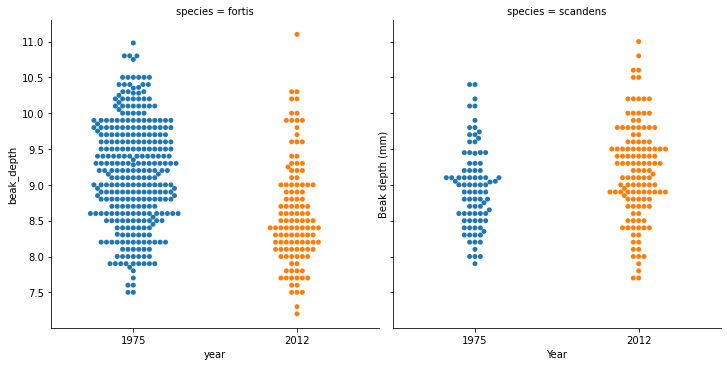

In [14]:
sns.catplot(x='year',y='beak_depth', col='species', data=df, kind='swarm')
plt.xlabel('Year')
plt.ylabel('Beak depth (mm)')

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the Scandens 2012 data set might have a higher mean and bigger variance. For the fortis we see that the 2012 data has a lower mean and a higher variance.

## ECDFs of beak depths for Scandens
While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.

In [15]:
# Create a function to calculate ECDF given a column series
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y  

In [16]:
bd_1975 = df.query('year == 1975 and species == "scandens"').beak_depth
bd_2012 = df.query('year == 2012 and species == "scandens"').beak_depth

In [17]:
# Compute ECDFs for the beak lengths for each year
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

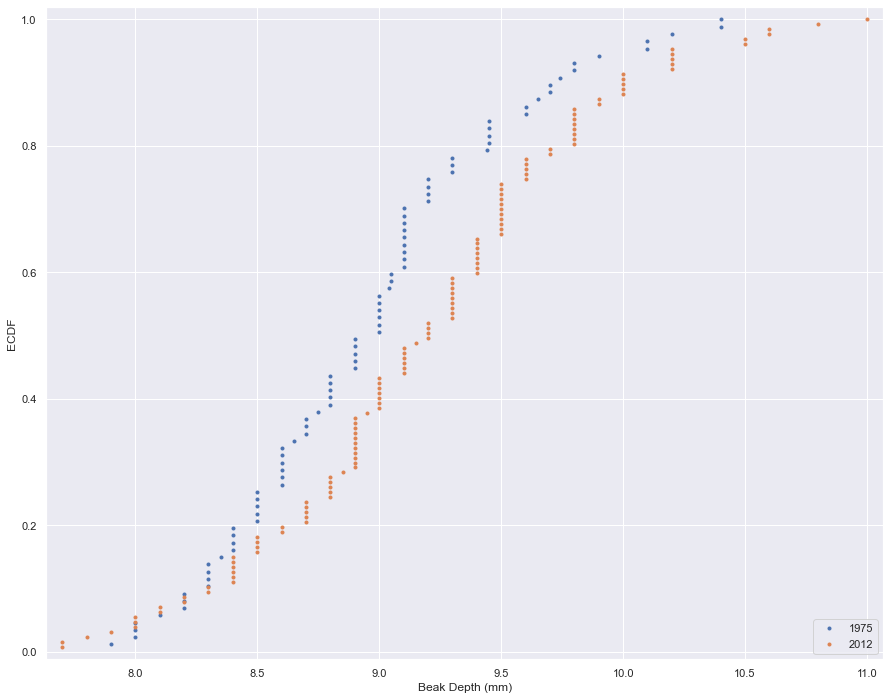

In [18]:
# Plot the ECDFs
sns.set()
fig, ax = plt.subplots(figsize=(15,12))
plt.plot(x_1975, y_1975, marker='.', linestyle='none', label='1975')
plt.plot(x_2012, y_2012, marker='.', linestyle='none', label='2012')
# Set margins
plt.margins(0.02)
# Label axes and make a legend
plt.xlabel('Beak Depth (mm)')
plt.ylabel('ECDF')
plt.legend(loc='lower right')

The ECDF is much more revealing about the differences than the swamplot. From it we can clearly see the mean of 2012 is much larger.

## Parameter estimates of beak depths for G. scandens

We will estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval using bootstrap replicates functions

### Create functions we will use

In [19]:
# Bootstrap replicate function
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data"""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [20]:
def draw_bs_reps(data, func, size=1):
    """ Draw bootstrap replicates."""
    
    # Initialize array of replicates bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates

In [21]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [22]:
# Compute the difference of the sample means: mean_diff
mean_diff = diff_of_means(bd_2012, bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, size=10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

Text(0, 0.5, 'ECDF')

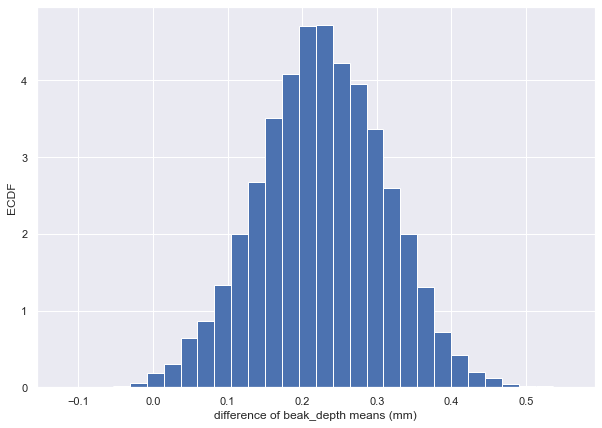

In [23]:
# Plot out the histogram
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(bs_diff_replicates, bins=30, density=True)
plt.xlabel('difference of beak_depth means (mm)')
plt.ylabel('ECDF')

In [24]:
# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5,97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.2262204724409429 mm
95% confidence interval = [0.05658107 0.38906188] mm


## Hypothesis test: Are beaks deeper in 2012?
Our plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten more deep. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [25]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, size=10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_1975 - bs_replicates_2012

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0035


We get a p-value of 0.0038, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.22 mm between the means. You should combine this with the statistical significance. Changing by 0.22 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would be double in only 400 years.

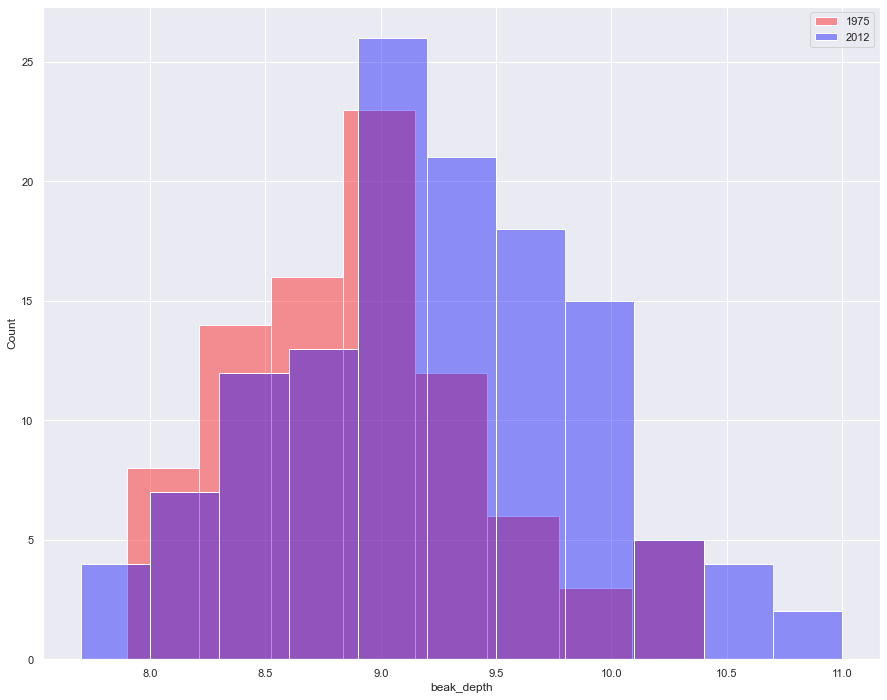

In [26]:
# Plot the histograms overlaying each other to see if we could spot the difference
fig,ax = plt.subplots(figsize=(15,12))
sns.histplot(bd_1975, color='red', alpha=0.4, label='1975')
sns.histplot(bd_2012, color='blue', alpha=0.4, label='2012')
plt.legend(loc='best')

## EDA of beak length and depth

In [27]:
df.head()

,band,species,beak_length,beak_depth,year
0,2,fortis,9.4,8.0,1975
1,9,fortis,9.2,8.3,1975
2,12,fortis,9.5,7.5,1975
3,15,fortis,9.5,8.0,1975
4,305,fortis,11.5,9.9,1975


In [28]:
# Create array of beak lengths for 1975 and 2012 respectively
bl_1975 = df.query('year == "1975" and species == "scandens"').beak_length
bl_2012 = df.query('year == "2012" and species == "scandens"').beak_length

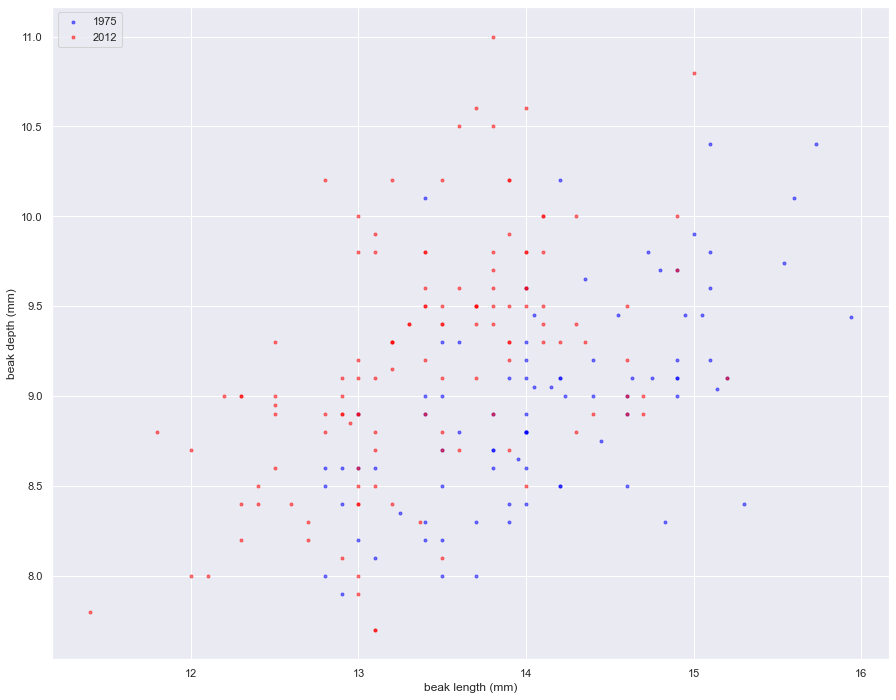

In [29]:
# Make scatter plot of 1975 data
plt.figure(figsize=(15, 12))
plt.scatter(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
plt.scatter(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

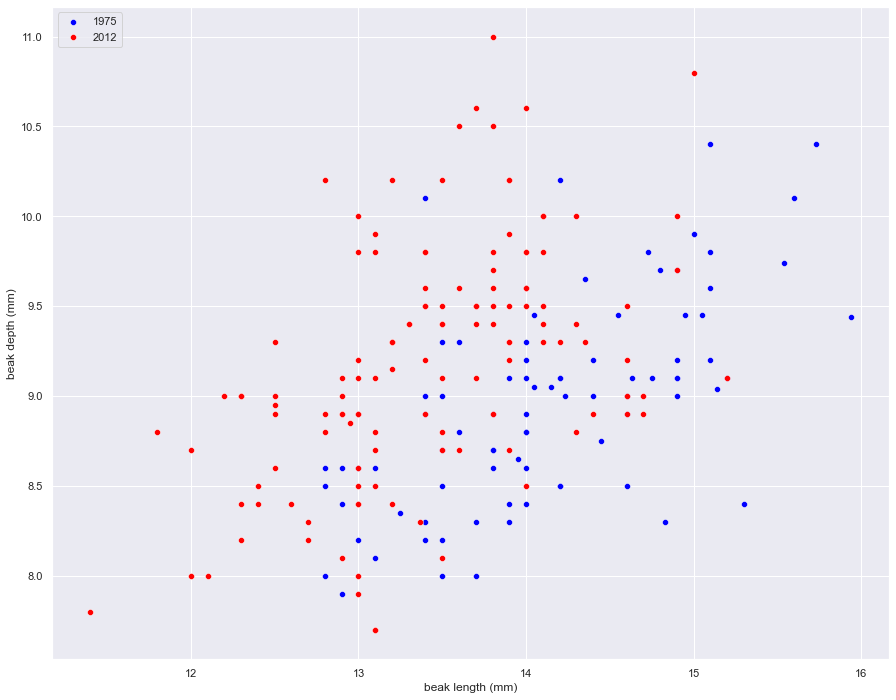

In [30]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.scatterplot(x=bl_1975, y=bd_1975, color='blue', ax=ax)
sns.scatterplot(x=bl_2012, y=bd_2012, color='red', ax=ax)
# Label axes and make legend
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('1975', '2012'), loc='upper left')

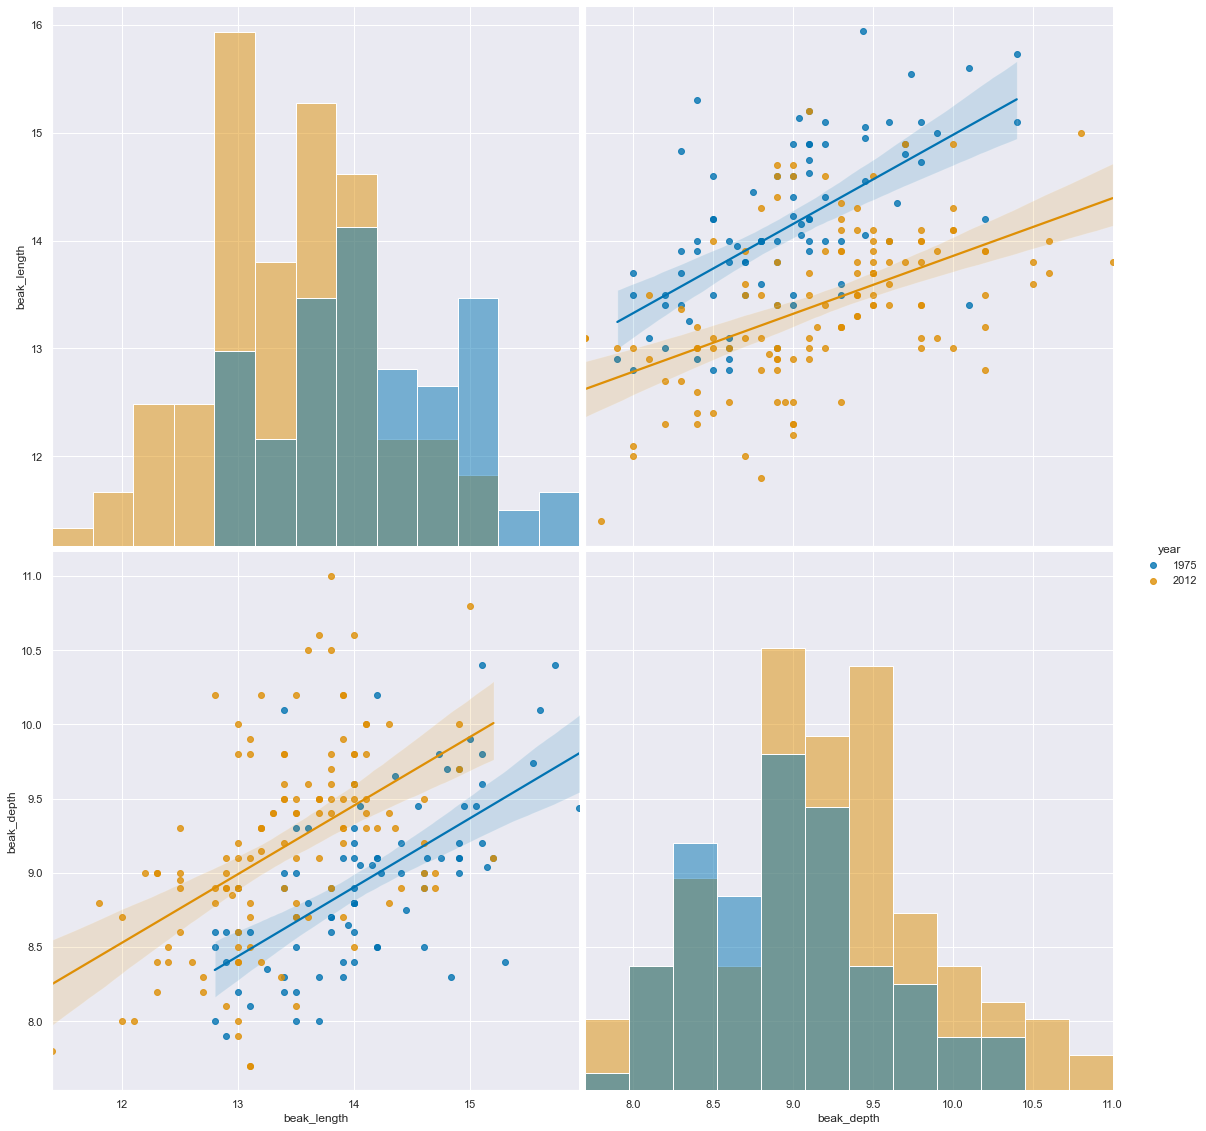

In [61]:
sns.pairplot(df.query('species == "scandens"'), vars=['beak_length','beak_depth'],
            kind='reg',
            diag_kind='hist',
            hue='year',
            palette='colorblind',
            height=8)